In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy
import random

In [8]:
data_train = pd.read_csv('data_train.csv')

In [9]:
# Define the device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Create a PyTorch dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class SleepDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.from_numpy(self.sequences[idx]).float(), torch.from_numpy(np.array(self.labels[idx])).float()

In [10]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Create a function to impute the missing values in the dataset
def impute_missing_values (dataframe, method = 'LOCF', limit = 20):

    # create a missing mask (column) fthat would indicate whether the values in any of the columns of mydata are missing
    # 1 indicates missing, 0 indicates not missing
    missing_mask = dataframe.isnull().sum(axis=1).astype(bool).astype(int)
    dataframe_imputed = dataframe.copy()
    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask.rename('ifmissing')], axis=1)

    if method == 'LOCF': 

        dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

        # fill the rest with backward fill 
        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

    elif method =='NOCB':

        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

        # fill the rest with forward fill
        #dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

    elif method == 'linear interpolation':
            
        dataframe_imputed.interpolate(method='linear', inplace=True, limit = limit)

    elif method == 'quadratic interpolation':

        dataframe_imputed.interpolate(method='quadratic', inplace=True, limit = limit)

    elif method == 'mean':

        dataframe_imputed.fillna(dataframe.mean(), inplace=True, limit = limit)

    elif method == 'median':

        dataframe_imputed.fillna(dataframe.median(), inplace=True, limit = limit)

    elif method == 'MICE':

        # Define an imputer
        imp = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                            missing_values=np.nan, 
                            sample_posterior=False,
                            max_iter=10, 
                            random_state=0, 
                            verbose=2)
                            

        columns = dataframe_imputed.columns

        # Apply the imputer
        df_imputed = imp.fit_transform(dataframe_imputed)

        # Convert back to DataFrame
        dataframe_imputed = pd.DataFrame(df_imputed, columns=columns)
    
    elif method == 'None':
        dataframe_imputed = dataframe_imputed

    missing_mask_new = dataframe_imputed.isnull().sum(axis=1).astype(bool).astype(int)

    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask_new.rename('ifmissing_after_imputation')], axis=1)

    return dataframe_imputed


In [11]:


# Create a function for creating sliding windows of selected length 

def create_sliding_windows(data,  window_size_minutes=5, 
                           ifmissing = True, random_seed = 42, ifoutputsubjects = 0, 
                           train_proportion = 0.6, ifoutput_end_points = 0,
                           resampling_method = None, resampling_proportion = 0.5, iftest = 1):

    # Assert whether therea are any NaNs in the data
    if not ifmissing:
        assert data.isnull().sum().sum() == 0, "There are NaNs in the data"

    
    # Create a list of all unique subjects
    subjects = data['Sbj_ID'].unique()

    # Randomly select some of the 80% of subjects to be in the training set, 20% to the validation set and 20% in the test set
    np.random.seed(random_seed)


    train_subjects = np.random.choice(subjects, size=int(train_proportion*len(subjects)), replace=False)
    

    if iftest == 1:
        val_proportions = (1 - train_proportion)/2
        val_subjects = np.random.choice(np.setdiff1d(subjects, train_subjects), size=int(val_proportions*len(subjects)), replace=False)
        test_subjects = np.setdiff1d(subjects, np.concatenate((train_subjects, val_subjects)))
    else: 
        val_proportions = 1 - train_proportion
        val_subjects = np.setdiff1d(subjects, train_subjects)
        test_subjects = []

    
    
    # Print the number of subjects in each set
    print(f'There are {len(train_subjects)} subjects in the training set, {len(val_subjects)} subjects in the validation set and {len(test_subjects)} subjects in the test set')
    
    
    # Create a new column in the dataframe that indicates whether the subject is in the training set, val set or the test set
    data['Set'] = 'train'
    data.loc[data['Sbj_ID'].isin(val_subjects), 'Set'] = 'val'
    data.loc[data['Sbj_ID'].isin(test_subjects), 'Set'] = 'test'

    # Sort your dataframe by Sbj_ID if not already sorted
    data = data.sort_values('Sbj_ID')

    # Convert the window size from minutes to 6-second epochs
    window_size = int((window_size_minutes*60)/6)

    # Create empty lists to store your sequences and labels
    train_sequences = []
    train_labels = []
    val_sequences = []
    val_labels = []
    test_sequences = []
    test_labels = []

    # Group the DataFrame by subject ID and iterate over each group, dividing into training and test sets
    if ifoutput_end_points == 1:
        test_end_points = []
        test_sleep_stages = []
        test_labels = []
        val_sleep_stages = []
        val_end_points = []
    for _, group in data.groupby('Sbj_ID'):
        
        # For each group, get the feature columns and convert them into numpy array
        if ifoutput_end_points == 1:
             group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'Old_label', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()
             group_old_labels = group['Old_label'].to_numpy()
             group_sleep_stages = group['SleepStage'].to_numpy()
             group_labels = group['Label'].to_numpy()
        else:
            group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()

        ifmissing_column = group['ifmissing_after_imputation'].to_numpy()

        train_test = group['Set'].iloc[0]
        
        if window_size == len(group_features):
            if train_test == 'train':
                print('got here')
                train_sequences.append(group_features)
                train_labels.append(group['Label'].iloc[0])
            elif train_test == 'val':
                val_sequences.append(group_features)
                val_labels.append(group['Label'].iloc[0])
            elif train_test == 'test':
                test_sequences.append(group_features)
                test_labels.append(group['Label'].iloc[0])
        elif window_size > len(group_features):
            continue

       
        # Iterate over the group array with a sliding window
        for i in range(len(group_features) - window_size):
            
            # If there are any NaNs in the window, skip it
            if ifmissing_column[i : i + window_size].sum() > 0:
                continue

            if train_test == 'train':

                # Append the window data to your sequences
                train_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                train_labels.append(group['Label'].iloc[i+window_size])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    test_end_points.append(group_old_labels[i+window_size])
                    test_sleep_stages.append(group_sleep_stages[i+window_size])
            
            elif train_test == 'val':
                # Append the window data to your sequences
                val_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                val_labels.append(group['Label'].iloc[i+window_size])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    val_end_points.append(group_old_labels[i+window_size])
                    val_sleep_stages.append(group_sleep_stages[i+window_size])
            

            elif train_test == 'test':
                
                # Append the window data to your sequences
                test_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                test_labels.append(group['Label'].iloc[i+window_size])
                        
            
    # Convert the sequences and labels into numpy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)
    val_sequences = np.array(val_sequences)
    val_labels = np.array(val_labels)
    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    
    if iftest == 1:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects, test_end_points, test_sleep_stages
            else: 
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_end_points, test_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels,  test_sequences, test_labels
    else:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels,  train_subjects, val_subjects, val_end_points, val_sleep_stages
            else: 
                return train_sequences, train_labels, val_sequences, val_labels, train_subjects, val_subjects
            
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, val_end_points, val_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels


In [12]:
import torch
from sklearn.metrics import mean_squared_error, r2_score

# Train function
def train_regression(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, ifplot = False):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        print ('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Train the model
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels.view(-1, 1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_loss = 0
            predictions, actuals = [], []
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)  # these are outputs now
                val_loss += criterion(outputs, labels.view(-1, 1)).item()

                predictions.extend(outputs.cpu().numpy().flatten())
                actuals.extend(labels.cpu().numpy())    

            # Calculate metrics
            mse = mean_squared_error(actuals, predictions)
            r2 = r2_score(actuals, predictions)
            mae = mean_absolute_error(actuals, predictions)

            if ifplot:
                print('-'*100)
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss/len(val_loader)}')
                print(f'Val Mean Squared Error: {mse}, Val R2 Score: {r2}')

                

        # Save the model training and validation losses for plotting 
        train_losses.append(loss.item())
        val_losses.append(val_loss/len(val_loader))

    return train_losses, val_losses, model, optimizer, mse, r2, mae

# Test function
def test_regression(model, test_loader, device, criterion):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # these are outputs now
            test_loss += criterion(outputs, labels.view(-1, 1)).item()

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy())

        print(f'Test Loss: {test_loss/len(test_loader)}')

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print('Mean Squared Error:', mse)
    print('R2 Score:', r2)
    print('Mean Absolute Error:', mae)

    return predictions, actuals, mse, r2, mae

In [13]:
def evaluate_performance_test(predictions, y_test):

    # check if the predictions are in the correct format
    if type(predictions) == list:
        predictions = np.array(predictions)

    # check if the y_test is in the correct format
    if type(y_test) == list:
        y_test = np.array(y_test)

    errors = abs(y_test - predictions)
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = sklearn.metrics.r2_score(y_test, predictions)


    print('Mean Absolute Error:', round(np.mean(errors), 2))
    print('Accuracy:', round(accuracy, 2), '%.')
    print('Mean Squared Error:', round(mse, 2))
    print('Root Mean Squared Error:', round(rmse, 2))
    print('R2:', round(r2, 2))
    


    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.scatter(y_test, predictions, alpha=0.2)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Predicted time to sleep onset')
    plt.title('Actual vs Predicted time to sleep onset')
    plt.show()
    plt.close()

    residuals = y_test - predictions
    plt.scatter(y_test, residuals, alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Residuals')
    plt.title('Actual vs Residuals')
    plt.show()
    plt.close()

    plt.hist(residuals)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals distribution')
    plt.show()
    plt.close()

    # for each actual, plot the mean residual 
    # round y_test to 0.1 decimal place
    y_test = np.round(y_test, 1)

    predictions_residuals_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in predictions_residuals_dict:
            predictions_residuals_dict[y_test[i]] = []
        predictions_residuals_dict[y_test[i]].append(residuals[i])
    
    # sort it in ascending order of keys
    predictions_residuals_dict = dict(sorted(predictions_residuals_dict.items()))


    actual_predictions_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in actual_predictions_dict:
            actual_predictions_dict[y_test[i]] = []
        actual_predictions_dict[y_test[i]].append(predictions[i])
    
    # sort it in ascending order of keys
    actual_predictions_dict = dict(sorted(actual_predictions_dict.items()))

    
    predictions_residuals_mean_dict = {}
    for key in predictions_residuals_dict:
        predictions_residuals_mean_dict[key] = np.mean(predictions_residuals_dict[key])
    
    # sort it in ascending order of keys
    predictions_residuals_mean_dict = dict(sorted(predictions_residuals_mean_dict.items()))


    residuals_std_dict = {}
    for key in predictions_residuals_dict:
        residuals_std_dict[key] = np.std(predictions_residuals_dict[key])
    # sort it in ascending order of keys
    residuals_std_dict = dict(sorted(residuals_std_dict.items()))

    
    actuals_predictions_mean_dict = {}
    for key in actual_predictions_dict:
        actuals_predictions_mean_dict[key] = np.mean(actual_predictions_dict[key])
    
    # sort it in ascending order of keys
    actuals_predictions_mean_dict = dict(sorted(actuals_predictions_mean_dict.items()))

    predictions_std_dict = {}
    for key in actual_predictions_dict:
        predictions_std_dict[key] = np.std(actual_predictions_dict[key])
    # sort it in ascending order of keys
    predictions_std_dict = dict(sorted(predictions_std_dict.items()))

    plt.plot(list(predictions_residuals_mean_dict.keys()), list(predictions_residuals_mean_dict.values()))
    # create std shading
    plt.fill_between(list(predictions_residuals_mean_dict.keys()),
                        np.array(list(predictions_residuals_mean_dict.values())) - np.array(list(residuals_std_dict.values())),
                        np.array(list(predictions_residuals_mean_dict.values())) + np.array(list(residuals_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = 0)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean Residuals for this actual')
    plt.title('Actual vs Residuals')
    plt.show()

    plt.plot(list(actuals_predictions_mean_dict.keys()), list(actuals_predictions_mean_dict.values()))
    # create std shading
    plt.fill_between(list(actuals_predictions_mean_dict.keys()),
                        np.array(list(actuals_predictions_mean_dict.values())) - np.array(list(predictions_std_dict.values())),
                        np.array(list(actuals_predictions_mean_dict.values())) + np.array(list(predictions_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = y)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean Prediction for this actual')
    plt.title('Actual vs Predictions')
    plt.show()

    return predictions, errors, mape, accuracy, residuals

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SleepOnsetESNRegressor(nn.Module):
    def __init__(self, input_size, reservoir_size = 100, output_size=1):
        super(SleepOnsetESNRegressor, self).__init__()
        
        # Reservoir parameters
        self.reservoir_size = reservoir_size
        
        # Sparse reservoir weights
        self.reservoir_weights = torch.randn(reservoir_size, reservoir_size) * 0.1
        self.reservoir_weights = nn.Parameter(self.reservoir_weights, requires_grad=False)  # No training
        
        # Input weights (fixed)
        self.input_weights = torch.randn(reservoir_size, input_size) * 0.1
        self.input_weights = nn.Parameter(self.input_weights, requires_grad=False)  # No training
        
        # Readout weights (trainable)
        self.fc = nn.Linear(reservoir_size, output_size)

    def forward(self, x):
        # Reservoir update
        batch_size, seq_len, _ = x.size()
        reservoir_state = torch.zeros(batch_size, self.reservoir_size).to(x.device)
        for t in range(seq_len):
            reservoir_state = torch.tanh(F.linear(x[:, t, :], self.input_weights) + F.linear(reservoir_state, self.reservoir_weights))
        
        # Linear readout
        out = self.fc(reservoir_state)
        return out



In [19]:
from sklearn.metrics import mean_squared_error

def training_loop_feature_RNN_regression(mydata, filling_limit, method, input_size, num_epochs,
                                         l2, lr, weight_decay, batch_size, device, 
                                            reservoir_size = 100, num_layers = 2,
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=0, ifoutputpredictions=0, 
                                         if_stratified_sampling=1, resampling_method=None,
                                         ifplot=False, ifsaveplots=True, output_path=None, loss_function = None,
                                         iftrainshuffle = False):

    # First, impute the missing values in the dataset
    mydata_imputed = impute_missing_values(mydata, method=method, limit=filling_limit)

    # Check if the dataset still has any missing values
    ifmissing = mydata_imputed.isnull().sum().sum()

    # Depending on the 'ifprobabilitiesanalysis' flag, process the data differently
    train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                    ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0, 
                                                                                                                    train_proportion = 0.8, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = 1)

    
    # Define the loss function for regression
    if loss_function is None:
        criterion = nn.MSELoss()
    else:
        criterion = loss_function

    # Create the training, validation, and test datasets
    train_dataset = SleepDataset(train_sequences, train_targets)
    val_dataset = SleepDataset(val_sequences, val_targets)
    test_dataset = SleepDataset(test_sequences, test_targets)

    # Create the data loaders
    if iftrainshuffle:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model (This model needs to be defined as a regression model)
    model = SleepOnsetESNRegressor(input_size=input_size, reservoir_size=reservoir_size)

    # Define the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    train_losses, val_losses, model, optimizer, mse, r2, mae= train_regression(model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, ifplot=ifplot)
    # Plot the training and validation losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    
    plt.show()
    plt.close()

    # Test the trained model if necessary
    if iftest == 1:
        predictions, actuals, mse, r2, mae = test_regression(model=model, test_loader=test_loader, device=device, criterion=criterion)
        #mse = mean_squared_error(actuals, predictions)
        print("Test MSE:", mse)
        print("Test R2:", r2)
        print("Test MAE:", mae)


        evaluate_performance_test(predictions, actuals)
        return train_losses, val_losses, model, predictions, actuals, mse

    else:
        if ifoutputpredictions:
            return train_losses, val_losses, model, predictions, actuals
        else:
            return train_losses, val_losses, model


## Regression from pretrained model

In [16]:
data_clean_onset = pd.read_csv('data_train_clean_onset.csv')

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 28.790870666503906, Validation Loss: 78.80514236479192
Val Mean Squared Error: 78.78712463378906, Val R2 Score: 0.02793795278108746
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 20.812227249145508, Validation Loss: 76.74381757749093
Val Mean Squared Error: 76.73271179199219, Val R2 Score: 0.053284941402513275
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 18.908693313598633, Validation Loss: 75.84511113045988
Val Mean Squared Error: 75.83470916748047, Val R2 Score: 0.06436431793172237
Epoch 4/30
--------------------------------------------------------------------------------------------

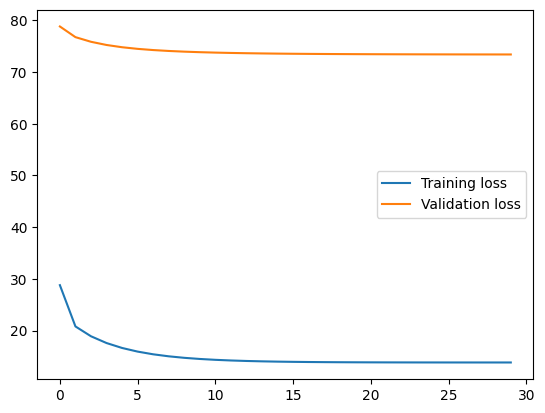

Test Loss: 68.9649770013415
Mean Squared Error: 68.989876
R2 Score: 0.18134938318687033
Mean Absolute Error: 7.1730595
Test MSE: 68.989876
Test R2: 0.18134938318687033
Test MAE: 7.1730595
Mean Absolute Error: 7.17
Accuracy: -inf %.
Mean Squared Error: 68.99
Root Mean Squared Error: 8.31
R2: 0.18


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


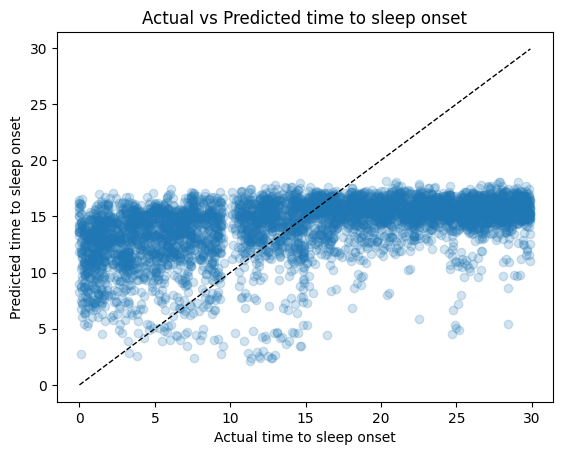

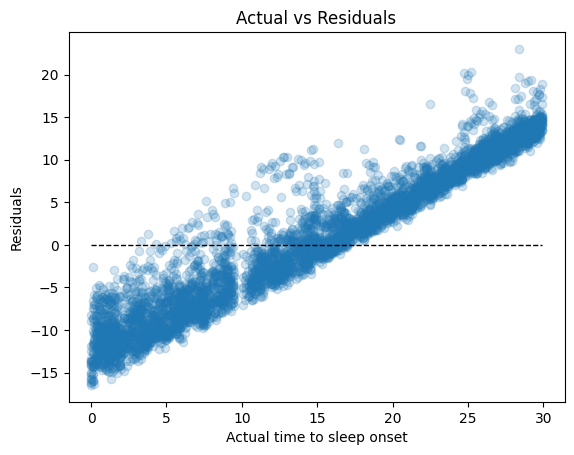

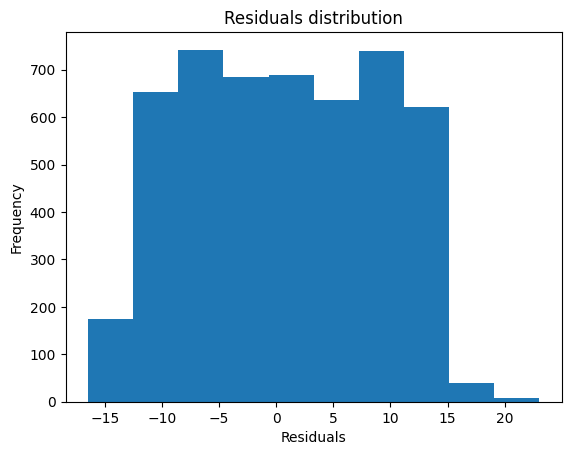

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


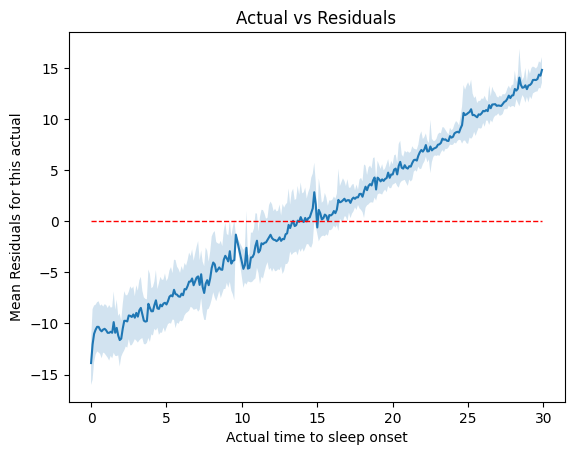

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


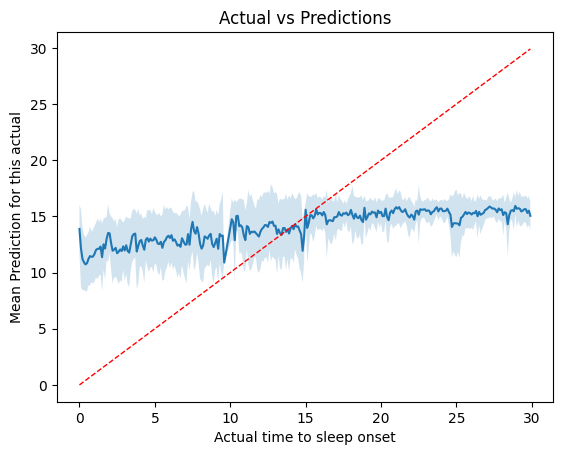

([28.790870666503906,
  20.812227249145508,
  18.908693313598633,
  17.600446701049805,
  16.647018432617188,
  15.944365501403809,
  15.422907829284668,
  15.0335693359375,
  14.741490364074707,
  14.521430969238281,
  14.355095863342285,
  14.22909164428711,
  14.13348388671875,
  14.06087589263916,
  14.005738258361816,
  13.963957786560059,
  13.932303428649902,
  13.908390045166016,
  13.890388488769531,
  13.876898765563965,
  13.866848945617676,
  13.859404563903809,
  13.853974342346191,
  13.850025177001953,
  13.847184181213379,
  13.845210075378418,
  13.843873023986816,
  13.843006134033203,
  13.842474937438965,
  13.842212677001953],
 [78.80514236479192,
  76.74381757749093,
  75.84511113045988,
  75.22785392202236,
  74.79201045551815,
  74.47754748809982,
  74.24586669416041,
  74.07175254902324,
  73.93851736349029,
  73.8349154893611,
  73.75322775905197,
  73.68805608676898,
  73.63553742500577,
  73.59285354573984,
  73.55791826586466,
  73.52914869745035,
  73.5053

In [20]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size= 200,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None)

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 12.205317497253418, Validation Loss: 74.97522654283691
Val Mean Squared Error: 74.97239685058594, Val R2 Score: 0.07500344732594577
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 9.278465270996094, Validation Loss: 73.50109070861662
Val Mean Squared Error: 73.50257873535156, Val R2 Score: 0.09313779217747231
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 7.975849151611328, Validation Loss: 73.00785735954304
Val Mean Squared Error: 73.01194763183594, Val R2 Score: 0.0991911169620675
Epoch 4/30
------------------------------------------------------------------------------------------------

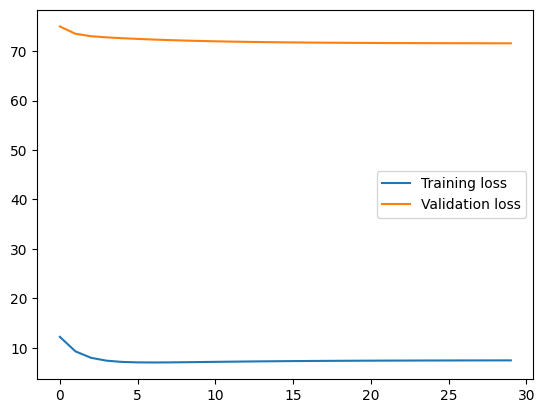

Test Loss: 63.9981173383884
Mean Squared Error: 64.02129
R2 Score: 0.24030770801008539
Mean Absolute Error: 6.858213
Test MSE: 64.02129
Test R2: 0.24030770801008539
Test MAE: 6.858213
Mean Absolute Error: 6.86
Accuracy: -inf %.
Mean Squared Error: 64.02
Root Mean Squared Error: 8.0
R2: 0.24


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


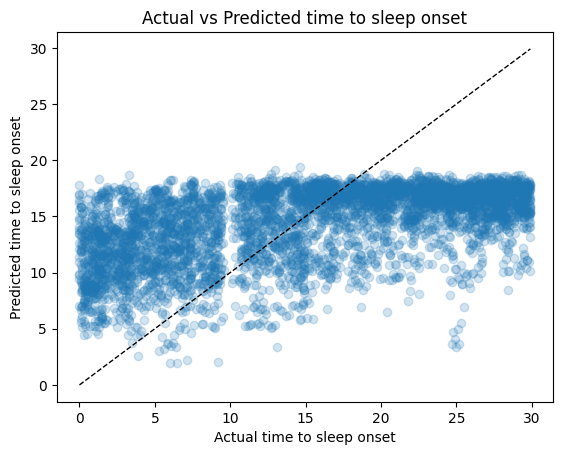

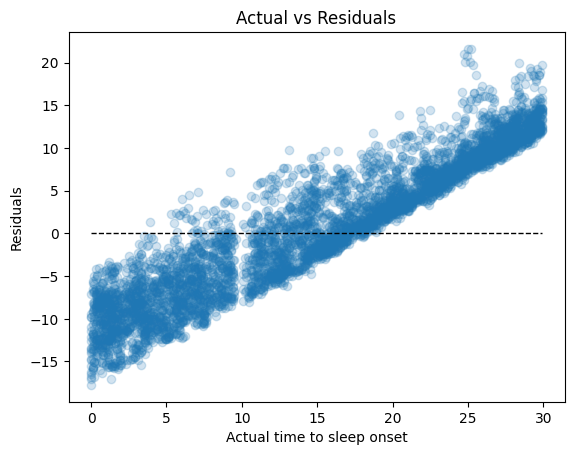

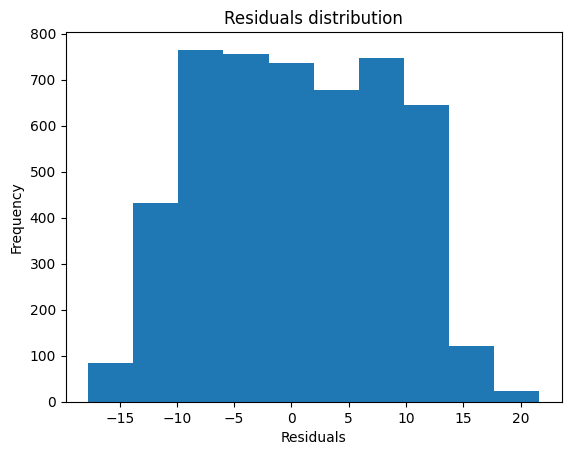

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


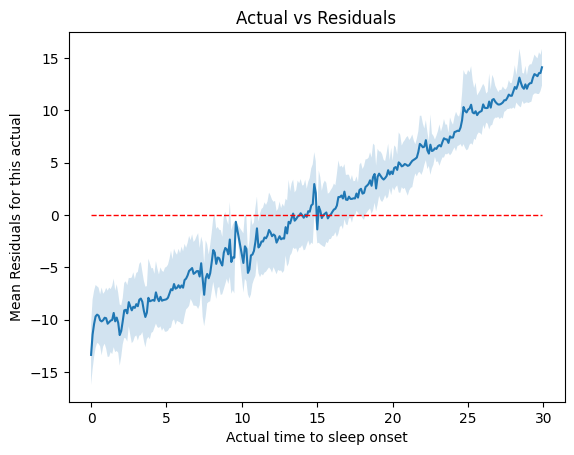

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


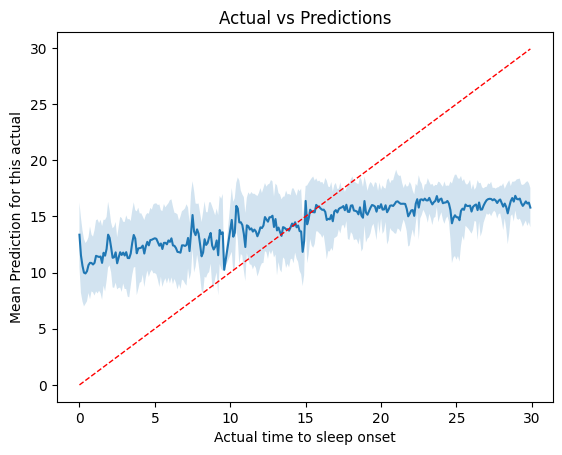

([12.205317497253418,
  9.278465270996094,
  7.975849151611328,
  7.393550872802734,
  7.142444610595703,
  7.048277378082275,
  7.0293288230896,
  7.0458292961120605,
  7.0780348777771,
  7.11599588394165,
  7.154745101928711,
  7.191835880279541,
  7.2261505126953125,
  7.2572855949401855,
  7.2851433753967285,
  7.309881687164307,
  7.3317179679870605,
  7.350895404815674,
  7.3676676750183105,
  7.382319927215576,
  7.395052433013916,
  7.406126499176025,
  7.415706157684326,
  7.42401123046875,
  7.43119478225708,
  7.437391757965088,
  7.442738056182861,
  7.447332859039307,
  7.451303958892822,
  7.454720973968506],
 [74.97522654283691,
  73.50109070861662,
  73.00785735954304,
  72.77253929807527,
  72.60473560300228,
  72.4620090708942,
  72.33644352531111,
  72.22647700519175,
  72.13104586303234,
  72.04877414695315,
  71.97811230936566,
  71.91753751442239,
  71.86563232702179,
  71.82115220902739,
  71.78300777399862,
  71.75027684263281,
  71.72216382018618,
  71.69800489

In [21]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size= 500,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None)

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 22.83835792541504, Validation Loss: 79.82431487678676
Val Mean Squared Error: 79.81149291992188, Val R2 Score: 0.015299404601349154
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 18.61077117919922, Validation Loss: 77.9149533248431
Val Mean Squared Error: 77.90834045410156, Val R2 Score: 0.03878021460440462
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 18.296865463256836, Validation Loss: 76.85684442117407
Val Mean Squared Error: 76.85159301757812, Val R2 Score: 0.051818255725157636
Epoch 4/15
----------------------------------------------------------------------------------------------

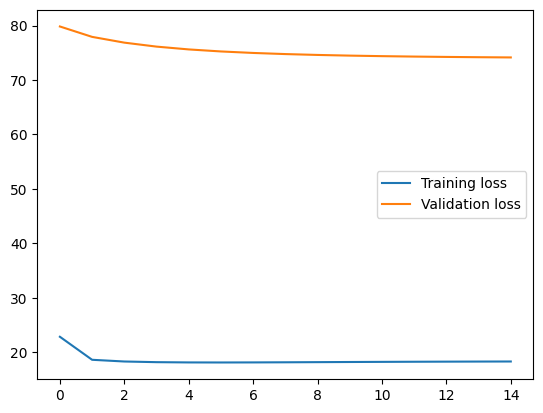

Test Loss: 69.36302119608109
Mean Squared Error: 69.388885
R2 Score: 0.17661464115323533
Mean Absolute Error: 7.2079387
Test MSE: 69.388885
Test R2: 0.17661464115323533
Test MAE: 7.2079387
Mean Absolute Error: 7.21
Accuracy: -inf %.
Mean Squared Error: 69.39
Root Mean Squared Error: 8.33
R2: 0.18


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


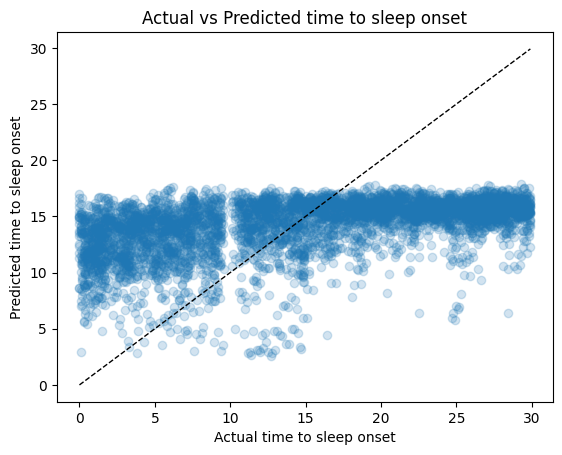

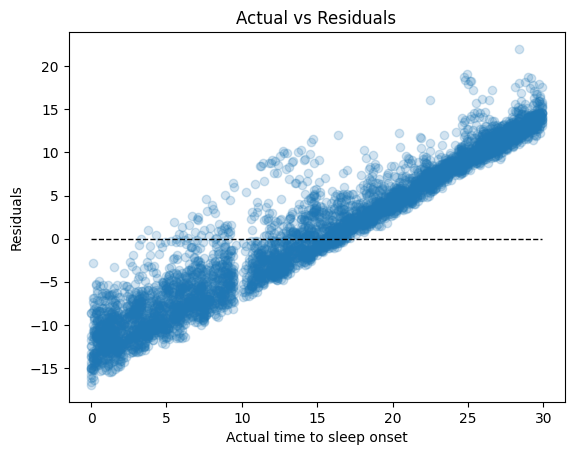

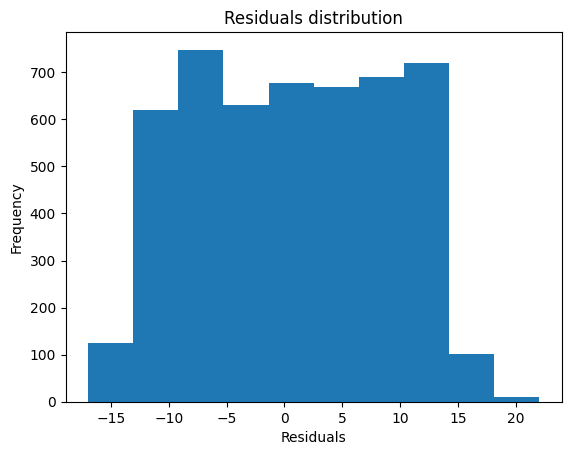

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


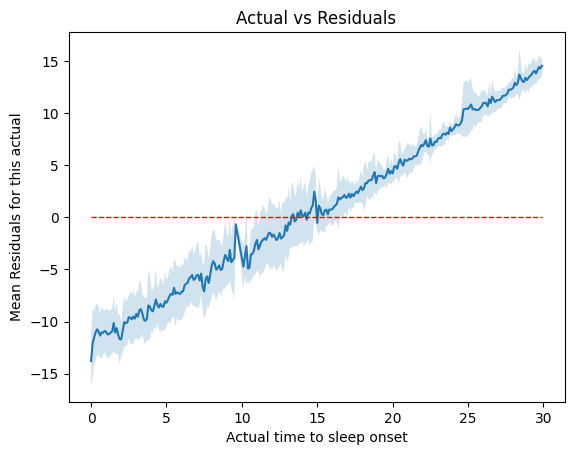

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


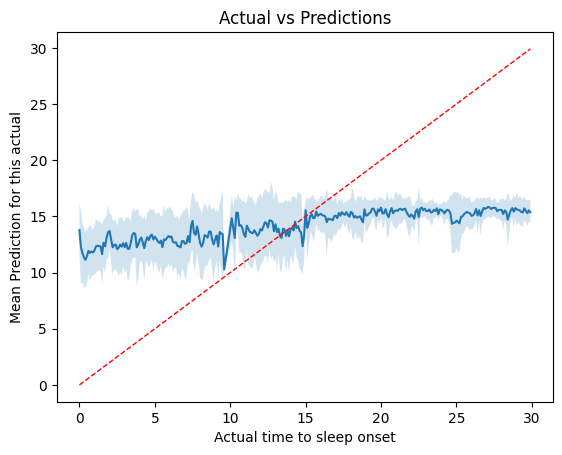

([22.83835792541504,
  18.61077117919922,
  18.296865463256836,
  18.17469596862793,
  18.125999450683594,
  18.117027282714844,
  18.1292667388916,
  18.151762008666992,
  18.178071975708008,
  18.204458236694336,
  18.2289981842041,
  18.250812530517578,
  18.269556045532227,
  18.285261154174805,
  18.298124313354492],
 [79.82431487678676,
  77.9149533248431,
  76.85684442117407,
  76.12637764980664,
  75.61058438710265,
  75.23816558678408,
  74.96327853686101,
  74.7561269982441,
  74.59707105240307,
  74.47294730350778,
  74.37473595102091,
  74.2961211679755,
  74.23260223341954,
  74.18086093100342,
  74.1384347419481],
 SleepOnsetESNRegressor(
   (fc): Linear(in_features=200, out_features=1, bias=True)
 ),
 [13.943261,
  13.338157,
  13.342708,
  14.444898,
  14.469704,
  13.335488,
  14.589835,
  13.98343,
  13.542429,
  14.075323,
  14.043765,
  9.589267,
  11.1328745,
  12.863082,
  11.906539,
  9.126523,
  10.163762,
  11.255176,
  14.495645,
  8.117965,
  7.3035245,
  6.5

In [22]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size= 200,
                                        num_layers = 2, num_epochs = 15, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None)

## Try on last 5 minutes of the clean onset

In [23]:
data_clean_5 = data_clean_onset[data_clean_onset['Label'] <= 5].copy()

In [24]:
data_clean_5

Label  Sbj_ID  Age  Gender  Race1  Race2  Race3  Race4  ifCleanOnset  \
249      5.0      12   80       1    1.0    0.0    0.0    0.0             1   
250      4.9      12   80       1    1.0    0.0    0.0    0.0             1   
251      4.8      12   80       1    1.0    0.0    0.0    0.0             1   
252      4.7      12   80       1    1.0    0.0    0.0    0.0             1   
253      4.6      12   80       1    1.0    0.0    0.0    0.0             1   
...      ...     ...  ...     ...    ...    ...    ...    ...           ...   
92695    0.4    6790   72       1    1.0    0.0    0.0    0.0             1   
92696    0.3    6790   72       1    1.0    0.0    0.0    0.0             1   
92697    0.2    6790   72       1    1.0    0.0    0.0    0.0             1   
92698    0.1    6790   72       1    1.0    0.0    0.0    0.0             1   
92699    0.0    6790   72       1    1.0    0.0    0.0    0.0             1   

       Time2Sleep  ...  wrseltr5  slpapnea5  cpap5  dntaldv5  uvula5  \
249          66.0  ...       9.0        0.0    0.0       0.0     0.0   
250          66.0  ...       9.0        0.0    0.0       0.0     0.0   
251          66.0  ...       9.0        0.0    0.0       0.0     0.0   
252          66.0  ...       9.0        0.0    0.0       0.0     0.0   
253          66.0  ...       9.0        0.0    0.0       0.0     0.0   
...           ...  ...       ...        ...    ...       ...     ...   
92695        57.0  ...      -1.0        0.0    0.0       0.0     0.0   
92696        57.0  ...      -1.0        0.0    0.0       0.0     0.0   
92697        57.0  ...      -1.0        0.0    0.0       0.0     0.0   
92698        57.0  ...      -1.0        0.0    0.0       0.0     0.0   
92699        57.0  ...      -1.0        0.0    0.0       0.0     0.0   

       insmnia5  rstlesslgs5  whiirs5c  epslpscl5c  hoostmeq5c  
249         0.0          0.0       9.0         5.0        12.0  
250         0.0          0.0       9.0         5.0        12.0  
251         0.0          0.0       9.0         5.0        12.0  
252         0.0          0.0       9.0         5.0        12.0  
253         0.0          0.0       9.0         5.0        12.0  
...         ...          ...       ...         ...         ...  
92695       0.0          0.0      13.0        11.0        15.0  
92696       0.0          0.0      13.0        11.0        15.0  
92697       0.0          0.0      13.0        11.0        15.0  
92698       0.0          0.0      13.0        11.0        15.0  
92699       0.0          0.0      13.0        11.0        15.0  

[15759 rows x 90 columns]

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 3.2014267444610596, Validation Loss: 2.6997033490075006
Val Mean Squared Error: 2.706159830093384, Val R2 Score: 0.0034092943324186553
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 3.32088565826416, Validation Loss: 2.6371662616729736
Val Mean Squared Error: 2.6410250663757324, Val R2 Score: 0.02739629701444868
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 3.312596559524536, Validation Loss: 2.5996109688723528
Val Mean Squared Error: 2.603663921356201, Val R2 Score: 0.0411552281793901
Epoch 4/15
-------------------------------------------------------------------------------------------

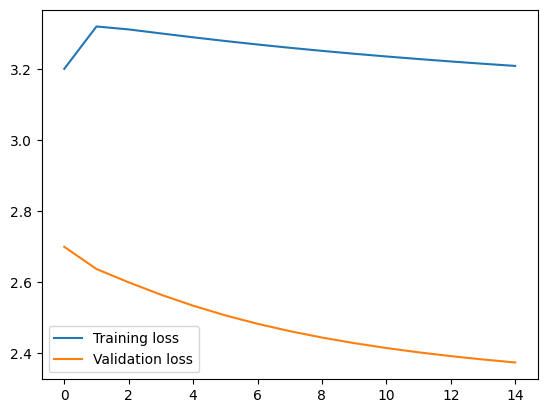

Test Loss: 2.3795330729977837
Mean Squared Error: 2.374166
R2 Score: 0.0799123105410291
Mean Absolute Error: 1.3413776
Test MSE: 2.374166
Test R2: 0.0799123105410291
Test MAE: 1.3413776
Mean Absolute Error: 1.34
Accuracy: -inf %.
Mean Squared Error: 2.37
Root Mean Squared Error: 1.54
R2: 0.08


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


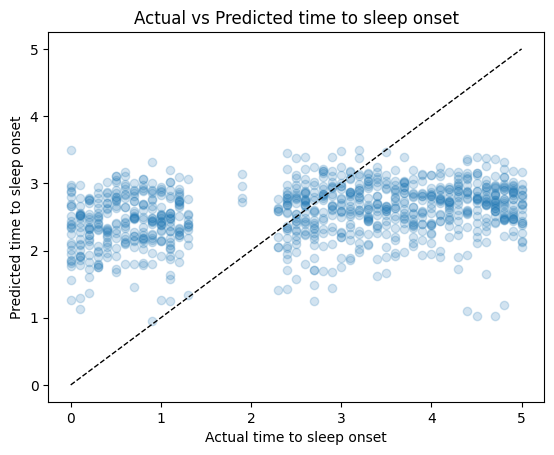

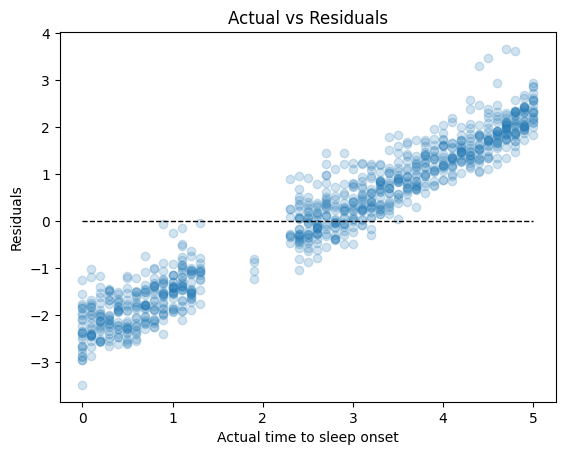

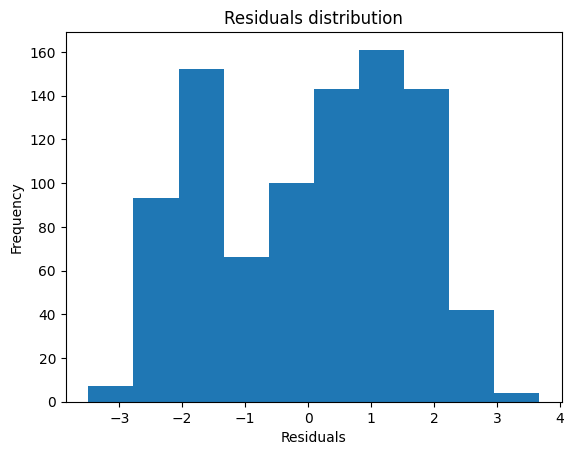

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


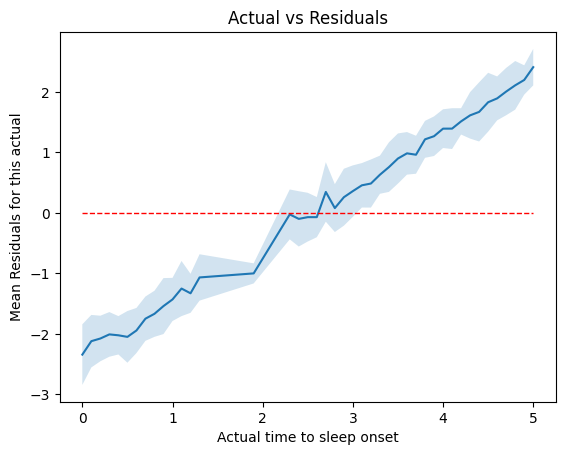

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


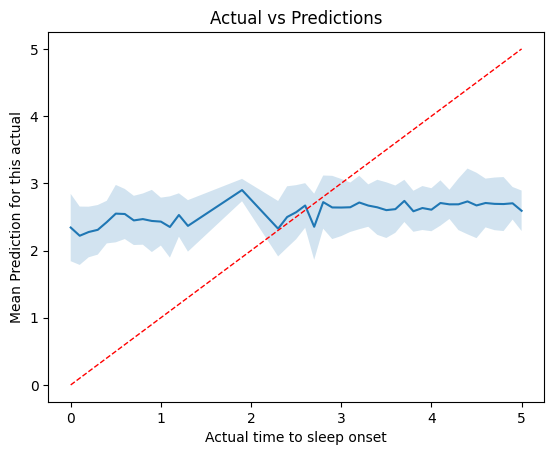

([3.2014267444610596,
  3.32088565826416,
  3.312596559524536,
  3.301351308822632,
  3.2903687953948975,
  3.279923439025879,
  3.2700822353363037,
  3.260840654373169,
  3.252164840698242,
  3.2440145015716553,
  3.2363460063934326,
  3.2291181087493896,
  3.2222940921783447,
  3.2158405780792236,
  3.209726333618164],
 [2.6997033490075006,
  2.6371662616729736,
  2.5996109688723528,
  2.5648276496816567,
  2.533796116157814,
  2.5065396141122886,
  2.4827599039784185,
  2.4620555153599493,
  2.444016209355107,
  2.428263227144877,
  2.4144630432128906,
  2.4023298908163,
  2.3916216205667564,
  2.382135179307726,
  2.373699731296963],
 SleepOnsetESNRegressor(
   (fc): Linear(in_features=200, out_features=1, bias=True)
 ),
 [2.3907425,
  1.8778236,
  2.1798556,
  2.3772395,
  1.7936723,
  1.819071,
  1.7943951,
  2.1196089,
  2.259932,
  1.9102114,
  1.9761703,
  2.1479642,
  1.9206221,
  1.8340037,
  2.3773582,
  1.5735905,
  2.4071987,
  2.9920614,
  2.957638,
  2.4974997,
  2.6377

In [26]:
training_loop_feature_RNN_regression(data_clean_5, filling_limit = 0, method = None, input_size = 86,
                                    num_epochs = 15,  reservoir_size= 200, num_layers = 2,
                                    l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 32, device = device, 
                                    random_seed=42, window_size_minutes=1, 
                                    iftest=1, ifoutputpredictions=0, 
                                    if_stratified_sampling=1, 
                                    ifplot=True, ifsaveplots=True, output_path=None)

## Try to create a custom loss function

In [27]:
import torch
import torch.nn as nn

class CustomMSELoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(CustomMSELoss, self).__init__()
        self.epsilon = epsilon  # Small value to prevent division by zero

    def forward(self, predictions, targets):
        # Compute error
        errors = (predictions - targets)**2

        # Compute weights inversely proportional to target values
        weights = 1.0 / (torch.abs(targets) + self.epsilon)

        # Weighted sum of errors
        loss = torch.sum(weights * errors) / torch.sum(weights)
        return loss

# Test the custom loss
predictions = torch.tensor([0.5, 0.2, 0.7])
targets = torch.tensor([0.1, 0.4, 0.8])
criterion = CustomMSELoss()
loss = criterion(predictions, targets)
print(loss)


tensor(0.1245)


There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 43.18948745727539, Validation Loss: 86.44690517698591
Val Mean Squared Error: 82.38445281982422, Val R2 Score: -0.01644529966313324
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 34.87562561035156, Validation Loss: 84.22392270452268
Val Mean Squared Error: 79.27781677246094, Val R2 Score: 0.02188390917071792
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 32.526702880859375, Validation Loss: 83.1836694789094
Val Mean Squared Error: 78.43694305419922, Val R2 Score: 0.03225839283929677
Epoch 4/30
-----------------------------------------------------------------------------------------------

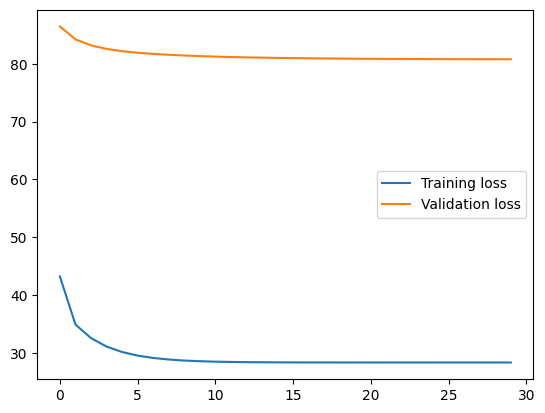

Test Loss: 75.63541002342335
Mean Squared Error: 72.695496
R2 Score: 0.13737753154323362
Mean Absolute Error: 7.2508254
Test MSE: 72.695496
Test R2: 0.13737753154323362
Test MAE: 7.2508254
Mean Absolute Error: 7.25
Accuracy: -inf %.
Mean Squared Error: 72.7
Root Mean Squared Error: 8.53
R2: 0.14


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


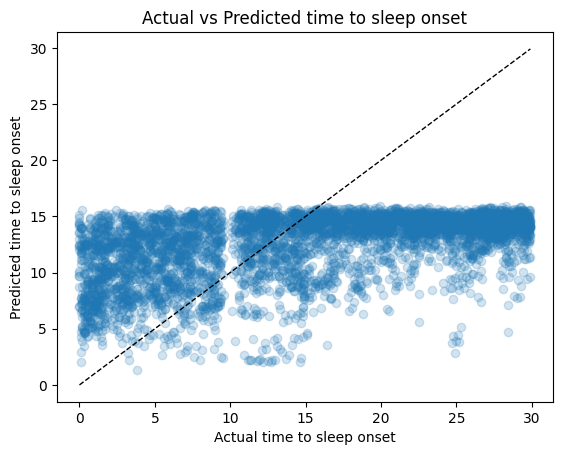

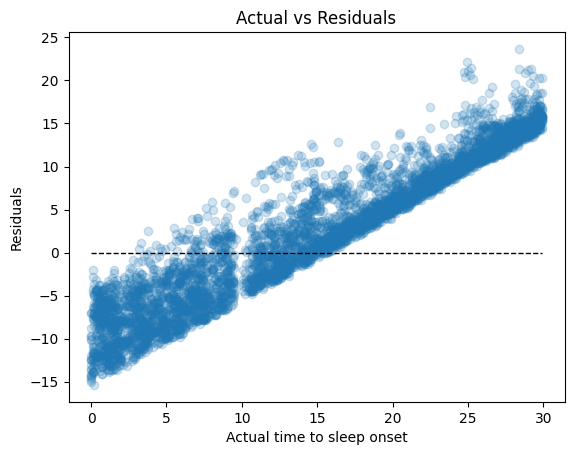

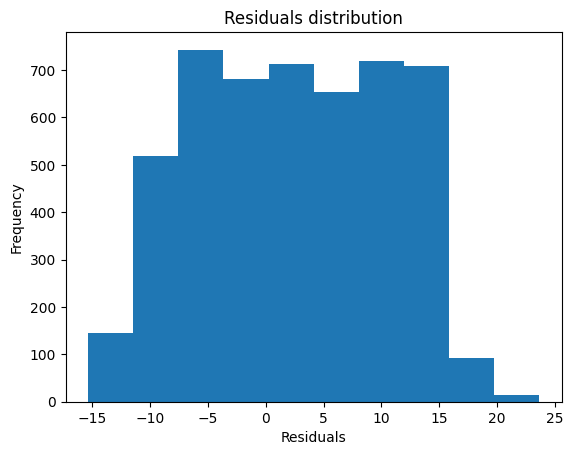

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


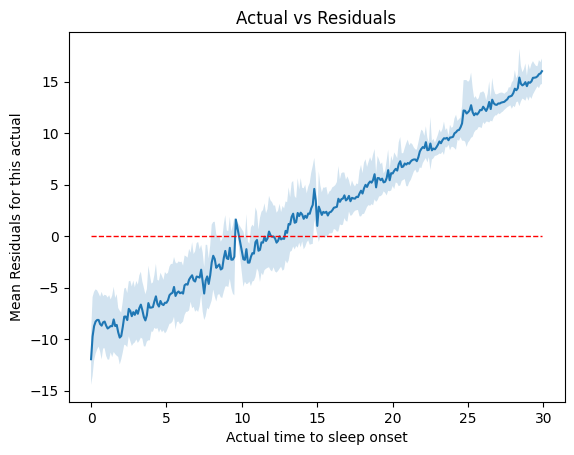

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


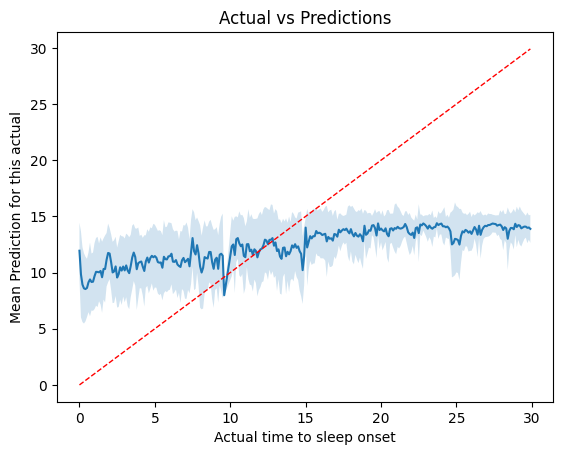

([43.18948745727539,
  34.87562561035156,
  32.526702880859375,
  31.064558029174805,
  30.115774154663086,
  29.49504852294922,
  29.087135314941406,
  28.818359375,
  28.6409969329834,
  28.523990631103516,
  28.44687843322754,
  28.396162033081055,
  28.362937927246094,
  28.34131622314453,
  28.327320098876953,
  28.318410873413086,
  28.312795639038086,
  28.309364318847656,
  28.307310104370117,
  28.306167602539062,
  28.305612564086914,
  28.305444717407227,
  28.305377960205078,
  28.30552864074707,
  28.305662155151367,
  28.30586814880371,
  28.30607795715332,
  28.306232452392578,
  28.306377410888672,
  28.306514739990234],
 [86.44690517698591,
  84.22392270452268,
  83.1836694789094,
  82.56925091993165,
  82.17567476428844,
  81.9032160736419,
  81.70197790297303,
  81.54604999076676,
  81.42119254453762,
  81.31899830900333,
  81.23414187012492,
  81.16298724791488,
  81.10291211508415,
  81.05193021208854,
  81.00849447338967,
  80.97139777686145,
  80.9396256482279,
 

In [28]:
prioritize_onset_loss = CustomMSELoss()
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size= 200,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None, loss_function=prioritize_onset_loss)

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 81.9871597290039, Validation Loss: 95.29520252105353
Val Mean Squared Error: 99.31881713867188, Val R2 Score: -0.22537850896193778
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 44.574581146240234, Validation Loss: 84.8141341036236
Val Mean Squared Error: 82.53253936767578, Val R2 Score: -0.018272292435803417
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 38.9310302734375, Validation Loss: 83.15673781790443
Val Mean Squared Error: 80.22252655029297, Val R2 Score: 0.010228270267010231
Epoch 4/15
----------------------------------------------------------------------------------------------

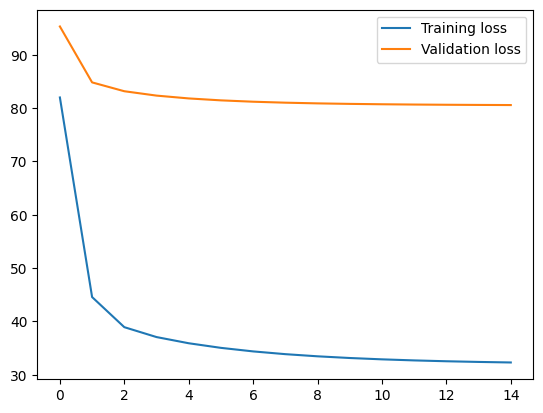

Test Loss: 76.1069688659448
Mean Squared Error: 74.85916
R2 Score: 0.11170290902045088
Mean Absolute Error: 7.374783
Test MSE: 74.85916
Test R2: 0.11170290902045088
Test MAE: 7.374783
Mean Absolute Error: 7.37
Accuracy: -inf %.
Mean Squared Error: 74.86
Root Mean Squared Error: 8.65
R2: 0.11


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


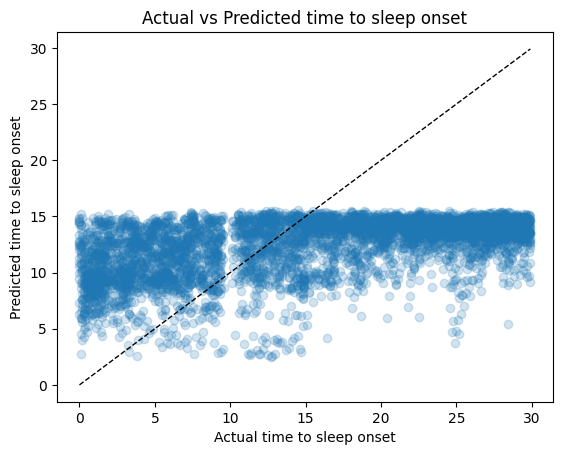

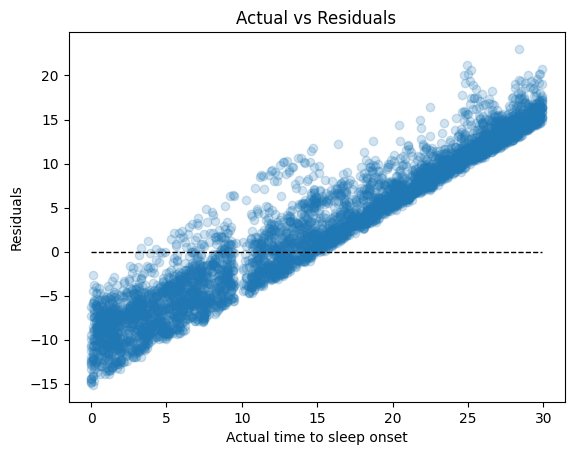

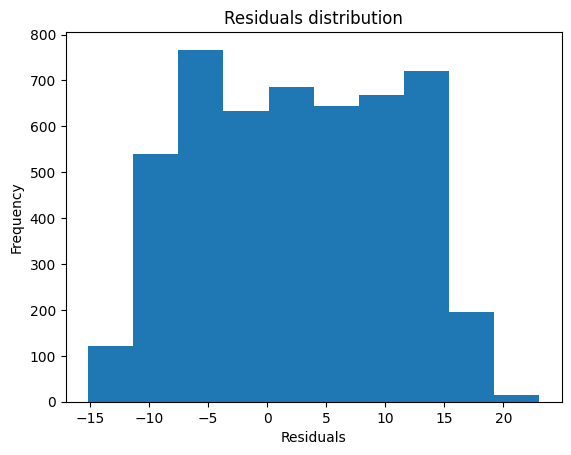

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


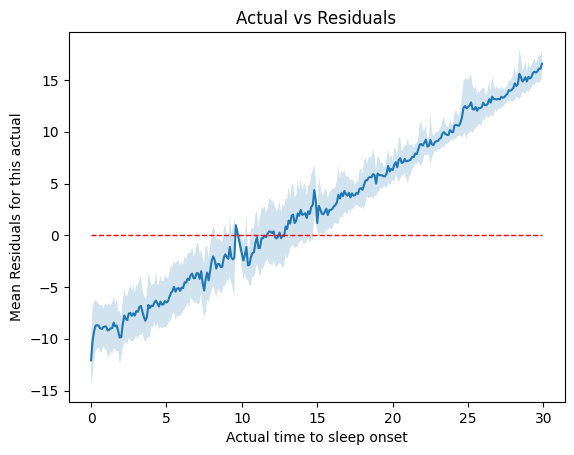

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


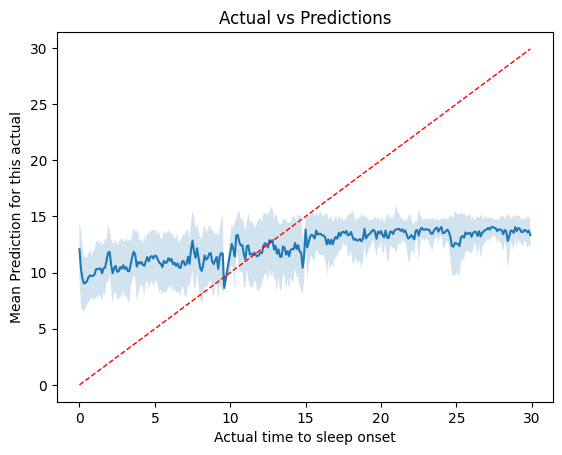

([81.9871597290039,
  44.574581146240234,
  38.9310302734375,
  37.07539367675781,
  35.915489196777344,
  35.0519905090332,
  34.38765335083008,
  33.871402740478516,
  33.46760940551758,
  33.15008544921875,
  32.899169921875,
  32.69998550415039,
  32.54116439819336,
  32.41408920288086,
  32.311920166015625],
 [95.29520252105353,
  84.8141341036236,
  83.15673781790443,
  82.33707941424203,
  81.80759445799363,
  81.4452599977722,
  81.19162162977295,
  81.01108141042091,
  80.88060914543834,
  80.78500435461063,
  80.71406761133993,
  80.66086112566896,
  80.62056533549283,
  80.58978172290969,
  80.56608119224374],
 SleepOnsetESNRegressor(
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 [11.848702,
  10.694721,
  10.826689,
  13.057078,
  11.7800865,
  12.18854,
  12.6093855,
  12.999434,
  12.535024,
  12.652591,
  13.042347,
  6.994244,
  8.164287,
  10.514955,
  9.128877,
  7.168402,
  7.7189236,
  8.708322,
  12.33949,
  6.306945,
  6.519131,
  5.0492735,
  6

In [29]:
prioritize_onset_loss = CustomMSELoss(epsilon=0.1)
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size= 100,
                                        num_layers = 2, num_epochs = 15, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None, loss_function=prioritize_onset_loss)

In [30]:
import torch
import torch.nn as nn

class CustomMSELossSquared(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(CustomMSELossSquared, self).__init__()
        self.epsilon = epsilon  # Small value to prevent division by zero

    def forward(self, predictions, targets):
        # Compute error
        errors = (predictions - targets)**2

        # Compute weights inversely proportional to target values
        weights = 1.0 / (torch.abs(targets) + self.epsilon)**2

        # Weighted sum of errors
        loss = torch.sum(weights * errors) / torch.sum(weights)
        return loss

# Test the custom loss
predictions = torch.tensor([0.5, 0.2, 0.7])
targets = torch.tensor([0.1, 0.4, 0.8])
criterion = CustomMSELossSquared()
loss = criterion(predictions, targets)
print(loss)


tensor(0.1509)


There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 89.04639434814453, Validation Loss: 96.87036582555723
Val Mean Squared Error: 105.43817138671875, Val R2 Score: -0.3008781565004699
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 54.548343658447266, Validation Loss: 89.26074073705318
Val Mean Squared Error: 89.76387023925781, Val R2 Score: -0.10749124162894974
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 48.27910232543945, Validation Loss: 87.9872188850029
Val Mean Squared Error: 87.43548583984375, Val R2 Score: -0.07876404638280321
Epoch 4/16
---------------------------------------------------------------------------------------------

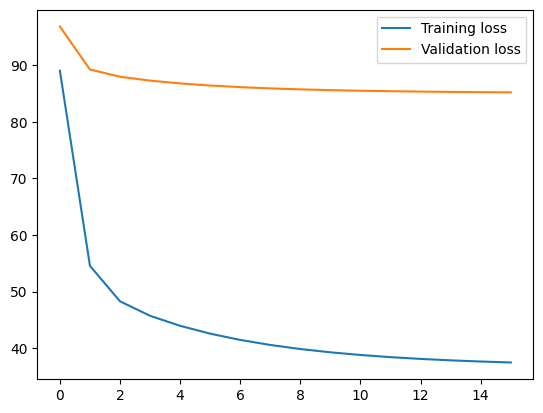

Test Loss: 82.10605603934098
Mean Squared Error: 82.993645
R2 Score: 0.015177165179074303
Mean Absolute Error: 7.7742476
Test MSE: 82.993645
Test R2: 0.015177165179074303
Test MAE: 7.7742476
Mean Absolute Error: 7.77
Accuracy: -inf %.
Mean Squared Error: 82.99
Root Mean Squared Error: 9.11
R2: 0.02


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


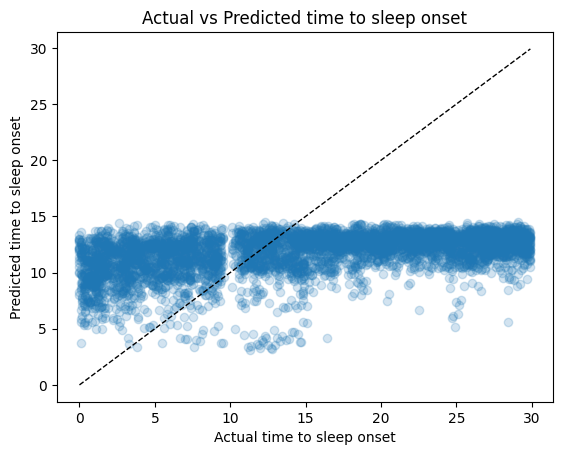

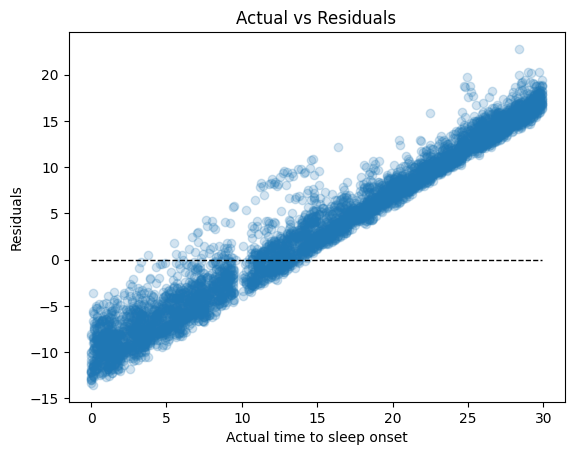

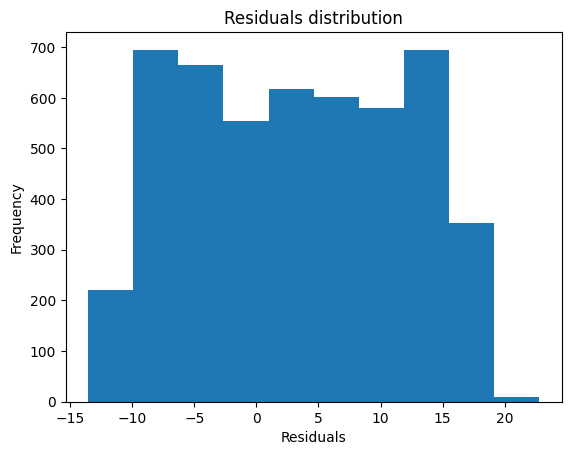

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


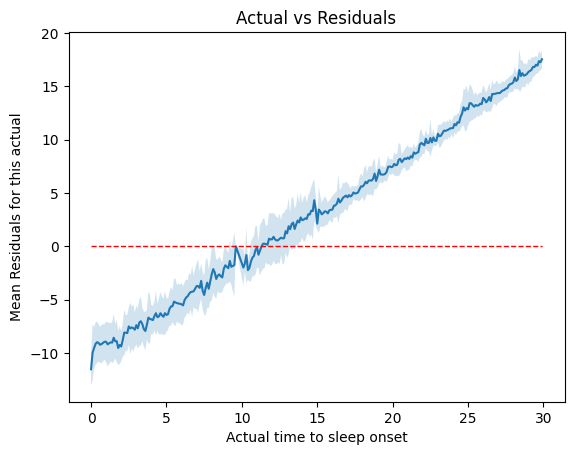

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


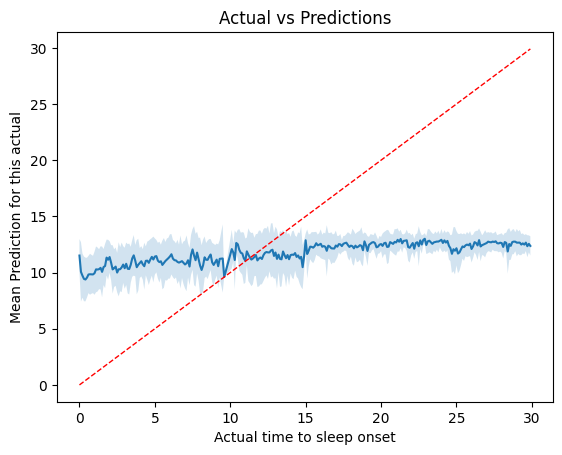

([89.04639434814453,
  54.548343658447266,
  48.27910232543945,
  45.714805603027344,
  43.94547653198242,
  42.56108093261719,
  41.45354080200195,
  40.56259536743164,
  39.84378433227539,
  39.26238250732422,
  38.79105758666992,
  38.408294677734375,
  38.096771240234375,
  37.84287643432617,
  37.63546371459961,
  37.465911865234375],
 [96.87036582555723,
  89.26074073705318,
  87.9872188850029,
  87.29672193627906,
  86.80308426191678,
  86.43073844325704,
  86.14531021464515,
  85.92440598387573,
  85.75207636867826,
  85.61668586730957,
  85.50964815874357,
  85.42456122467647,
  85.3565867271375,
  85.30207836607823,
  85.25816729463436,
  85.2227046181624],
 SleepOnsetESNRegressor(
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 [10.781387,
  10.799671,
  10.1750965,
  11.199657,
  10.667902,
  11.286048,
  11.412891,
  11.792563,
  11.58828,
  11.442379,
  10.527418,
  7.2531347,
  8.16535,
  9.445487,
  8.853489,
  7.882561,
  7.9942803,
  9.163327,
  9.328

In [31]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size=100,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay =0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELossSquared())

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 170.04722595214844, Validation Loss: 123.48128952470836
Val Mean Squared Error: 153.8085174560547, Val R2 Score: -0.8587522378658043
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 103.87163543701172, Validation Loss: 97.21380065766391
Val Mean Squared Error: 113.36974334716797, Val R2 Score: -0.3700559555700662
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 79.08905792236328, Validation Loss: 90.21966715048481
Val Mean Squared Error: 100.23344421386719, Val R2 Score: -0.2113058433167736
Epoch 4/16
-------------------------------------------------------------------------------------------

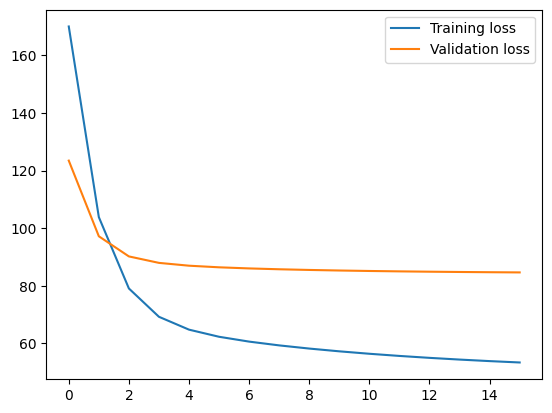

Test Loss: 90.5039251640143
Mean Squared Error: 99.047806
R2 Score: -0.12661729483383022
Mean Absolute Error: 8.509429
Test MSE: 99.047806
Test R2: -0.12661729483383022
Test MAE: 8.509429
Mean Absolute Error: 8.51
Accuracy: -inf %.
Mean Squared Error: 99.05
Root Mean Squared Error: 9.95
R2: -0.13


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


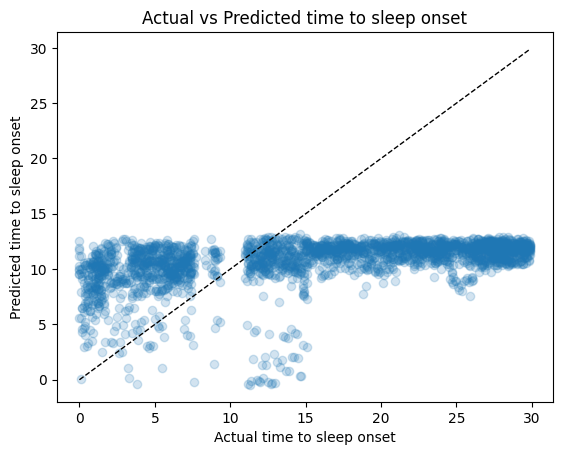

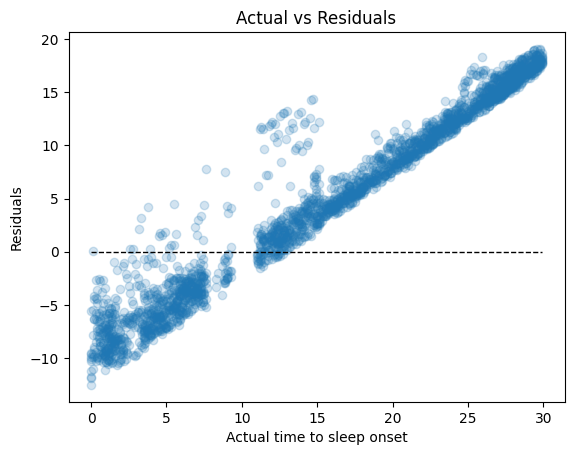

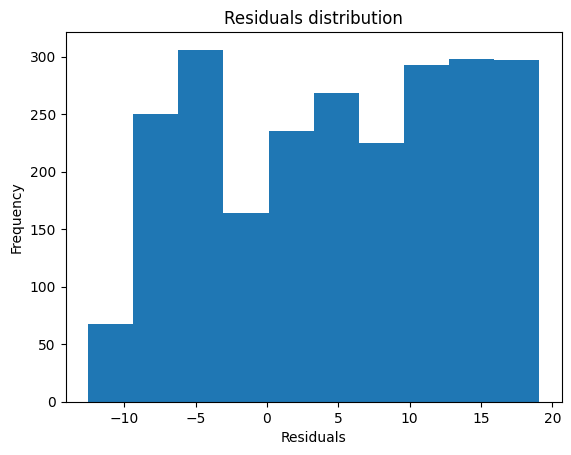

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


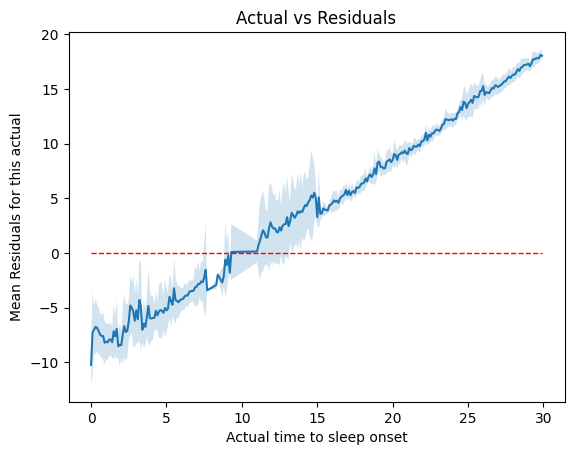

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


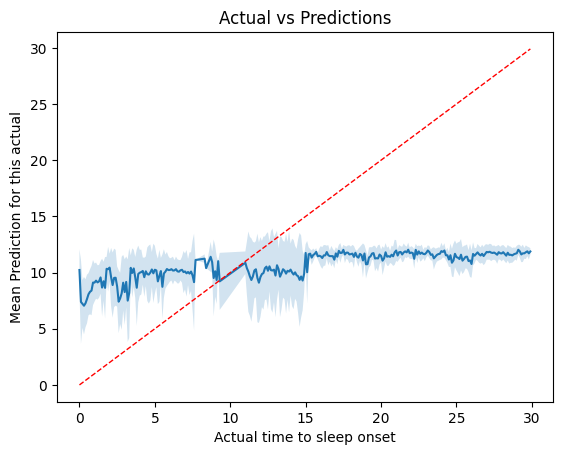

([170.04722595214844,
  103.87163543701172,
  79.08905792236328,
  69.25760650634766,
  64.79563903808594,
  62.321529388427734,
  60.642459869384766,
  59.331214904785156,
  58.22844696044922,
  57.26935958862305,
  56.42333221435547,
  55.67222213745117,
  55.003448486328125,
  54.40705490112305,
  53.87452697753906,
  53.39861297607422],
 [123.48128952470836,
  97.21380065766391,
  90.21966715048481,
  87.9758542586636,
  86.99762191598778,
  86.43764047985835,
  86.05260107533032,
  85.75878873960862,
  85.52247203817431,
  85.32762036891963,
  85.16508903961308,
  85.02871155028312,
  84.9138977401304,
  84.81702238676564,
  84.7351209225244,
  84.66575150616121],
 SleepOnsetESNRegressor(
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ),
 [11.315342,
  11.486066,
  11.353842,
  12.045344,
  11.403165,
  11.185579,
  11.689716,
  11.468153,
  11.193152,
  11.900063,
  11.76799,
  11.512064,
  11.525459,
  11.668831,
  11.680825,
  11.633635,
  11.282052,
  11.77267,
 

In [32]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size= 100,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELossSquared())

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 19.129220962524414, Validation Loss: 86.7378366871884
Val Mean Squared Error: 83.60986328125, Val R2 Score: -0.010412361835917094
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 17.807382583618164, Validation Loss: 85.5104950791911
Val Mean Squared Error: 83.18155670166016, Val R2 Score: -0.005236340539029882
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 16.927637100219727, Validation Loss: 84.6179751283244
Val Mean Squared Error: 82.61581420898438, Val R2 Score: 0.001600582994893629
Epoch 4/30
----------------------------------------------------------------------------------------------

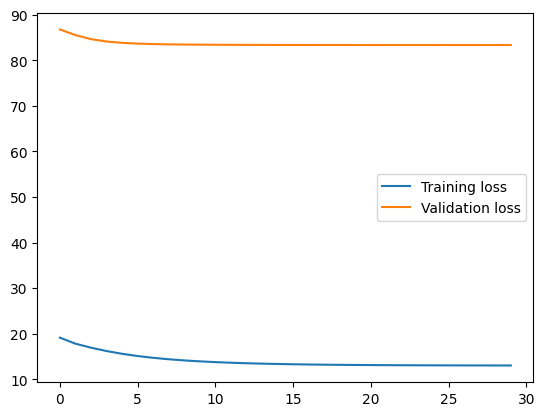

Test Loss: 80.71207140621387
Mean Squared Error: 81.04572
R2 Score: 0.07814698655892893
Mean Absolute Error: 7.401303
Test MSE: 81.04572
Test R2: 0.07814698655892893
Test MAE: 7.401303
Mean Absolute Error: 7.4
Accuracy: -inf %.
Mean Squared Error: 81.05
Root Mean Squared Error: 9.0
R2: 0.08


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


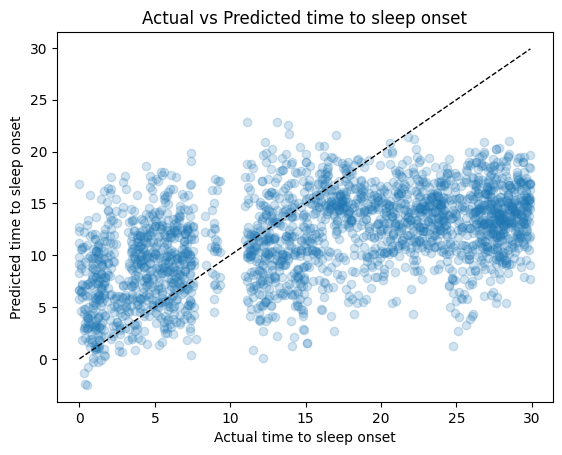

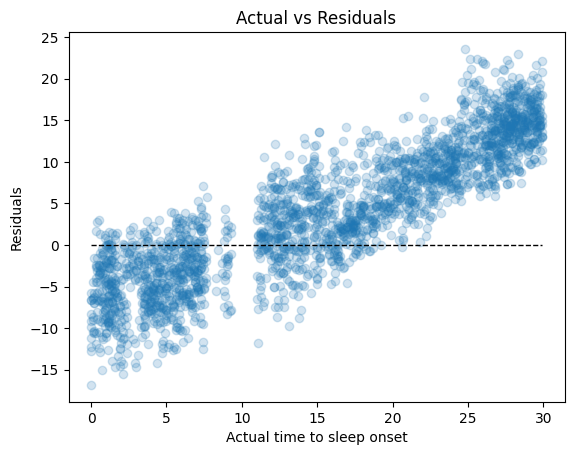

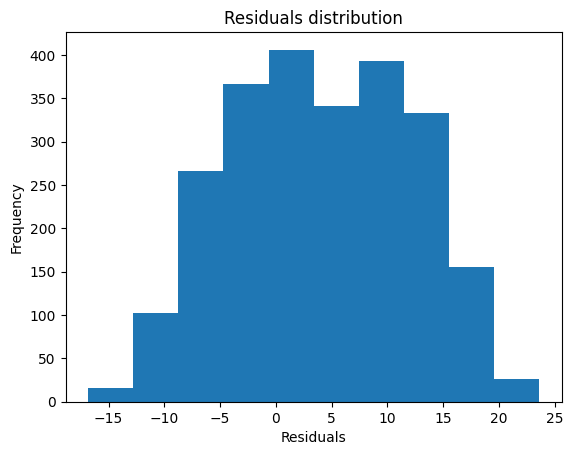

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


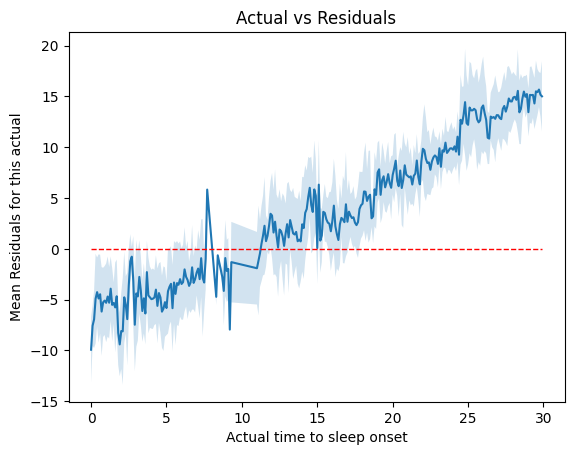

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


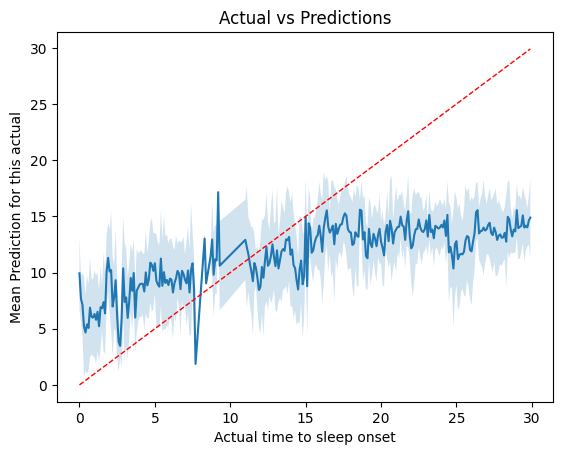

([19.129220962524414,
  17.807382583618164,
  16.927637100219727,
  16.194589614868164,
  15.588913917541504,
  15.09835147857666,
  14.704680442810059,
  14.389154434204102,
  14.135558128356934,
  13.930862426757812,
  13.76487922668457,
  13.629740715026855,
  13.51928997039795,
  13.428756713867188,
  13.354353904724121,
  13.293122291564941,
  13.242621421813965,
  13.200948715209961,
  13.166528701782227,
  13.13810920715332,
  13.114666938781738,
  13.095332145690918,
  13.079415321350098,
  13.06631851196289,
  13.0556058883667,
  13.046860694885254,
  13.039735794067383,
  13.033970832824707,
  13.029338836669922,
  13.025667190551758],
 [86.7378366871884,
  85.5104950791911,
  84.6179751283244,
  84.09832515842037,
  83.80551422897138,
  83.63757820505845,
  83.53730261325836,
  83.47441230949603,
  83.43298495443244,
  83.40447149778667,
  83.38413610583858,
  83.36926455874192,
  83.35817332016795,
  83.34983311828815,
  83.34352304433521,
  83.3387700131065,
  83.335211502

In [36]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size = 200,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.01, weight_decay = 0.01, batch_size = 32, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss())

## Try to shuffle the training data

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 27.693134307861328, Validation Loss: 132.19199562664852
Val Mean Squared Error: 151.03306579589844, Val R2 Score: -0.8252112999789207
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 75.34928131103516, Validation Loss: 140.4438007008161
Val Mean Squared Error: 161.03077697753906, Val R2 Score: -0.9460323581609977
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 23.906126022338867, Validation Loss: 131.7317677211288
Val Mean Squared Error: 150.12916564941406, Val R2 Score: -0.8142879007100172
Epoch 4/30
------------------------------------------------------------------------------------------

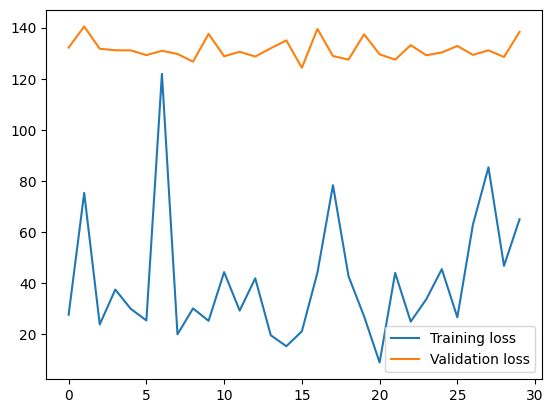

Test Loss: 147.0506747739994
Mean Squared Error: 170.21532
R2 Score: -0.9361108550404444
Mean Absolute Error: 10.678974
Test MSE: 170.21532
Test R2: -0.9361108550404444
Test MAE: 10.678974
Mean Absolute Error: 10.68
Accuracy: -inf %.
Mean Squared Error: 170.22
Root Mean Squared Error: 13.05
R2: -0.94


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


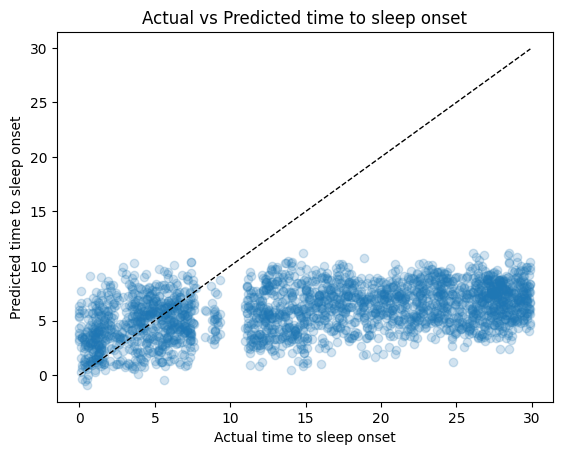

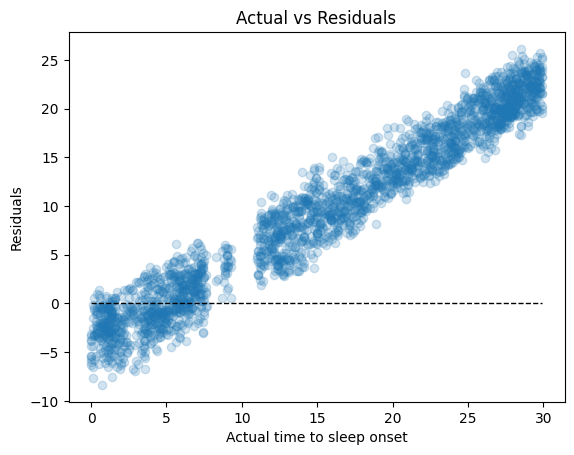

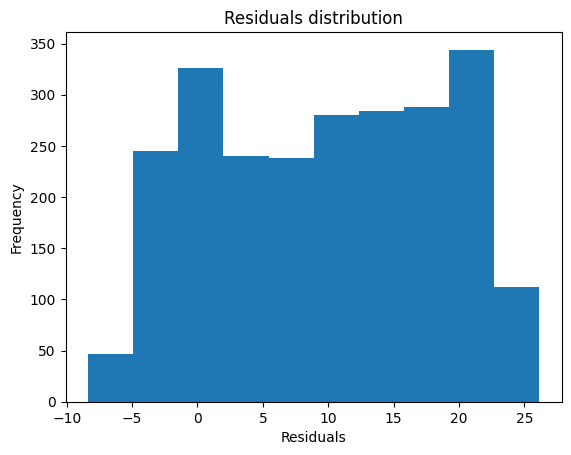

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


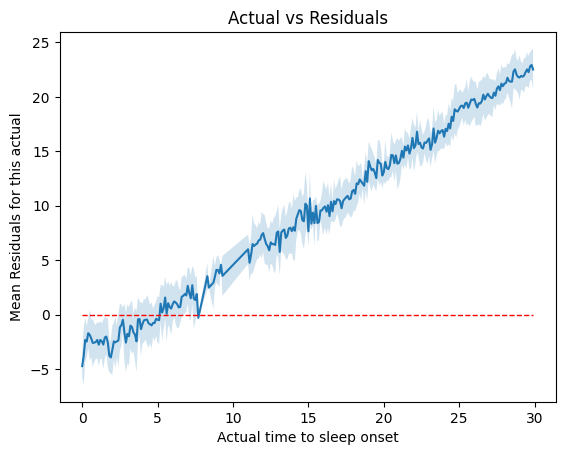

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


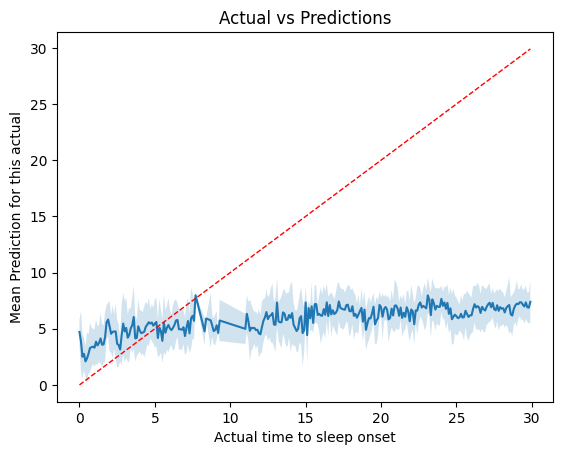

([27.693134307861328,
  75.34928131103516,
  23.906126022338867,
  37.52265930175781,
  29.961734771728516,
  25.45472526550293,
  121.90716552734375,
  20.021879196166992,
  30.15714454650879,
  25.304046630859375,
  44.35745620727539,
  29.300413131713867,
  41.93278121948242,
  19.664939880371094,
  15.371642112731934,
  21.19579315185547,
  44.14552688598633,
  78.3558120727539,
  42.768184661865234,
  27.088777542114258,
  9.012661933898926,
  44.04139709472656,
  24.992767333984375,
  33.731903076171875,
  45.508399963378906,
  26.686311721801758,
  62.907875061035156,
  85.36149597167969,
  46.811607360839844,
  65.04248809814453],
 [132.19199562664852,
  140.4438007008161,
  131.7317677211288,
  131.15187481854926,
  131.08678849367115,
  129.2347980915316,
  130.9439645662213,
  129.6964634570065,
  126.68629953798079,
  137.5494755526252,
  128.79720174871534,
  130.5266585464509,
  128.68666529181777,
  131.9317193354992,
  134.98831757804416,
  124.28893049544845,
  139.482

In [37]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size=100,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.001, weight_decay = 0.05, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss(), iftrainshuffle=True)

There are 247 subjects in the training set, 30 subjects in the validation set and 32 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 51.876564025878906, Validation Loss: 120.49458863586187
Val Mean Squared Error: 130.34014892578125, Val R2 Score: -0.6578027498698069
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 39.31385040283203, Validation Loss: 121.48610182962518
Val Mean Squared Error: 131.6158905029297, Val R2 Score: -0.6740288589493189
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 81.40483093261719, Validation Loss: 122.27312053922326
Val Mean Squared Error: 132.58041381835938, Val R2 Score: -0.6862965117775834
Epoch 4/16
------------------------------------------------------------------------------------------

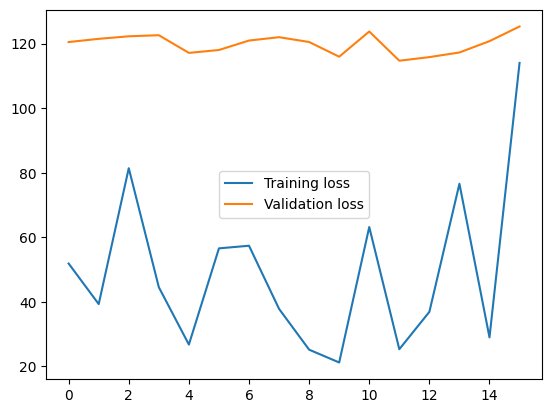

Test Loss: 119.9101050505644
Mean Squared Error: 132.16638
R2 Score: -0.6282523645989504
Mean Absolute Error: 9.204425
Test MSE: 132.16638
Test R2: -0.6282523645989504
Test MAE: 9.204425
Mean Absolute Error: 9.2
Accuracy: -inf %.
Mean Squared Error: 132.17
Root Mean Squared Error: 11.5
R2: -0.63


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


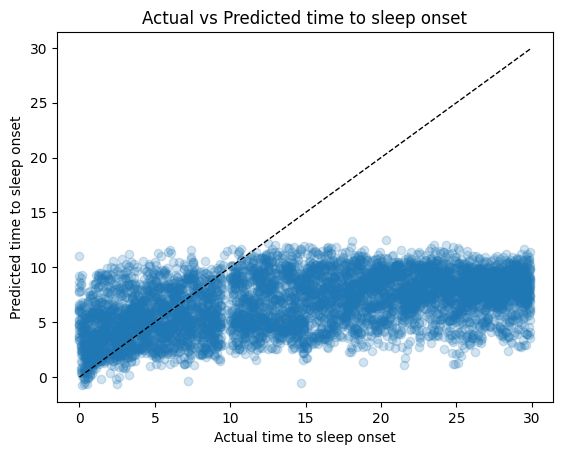

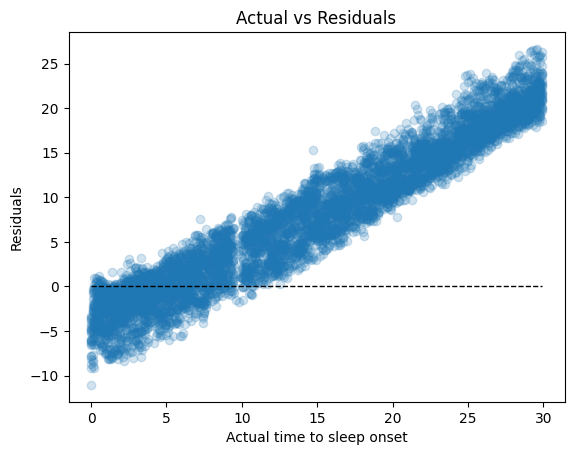

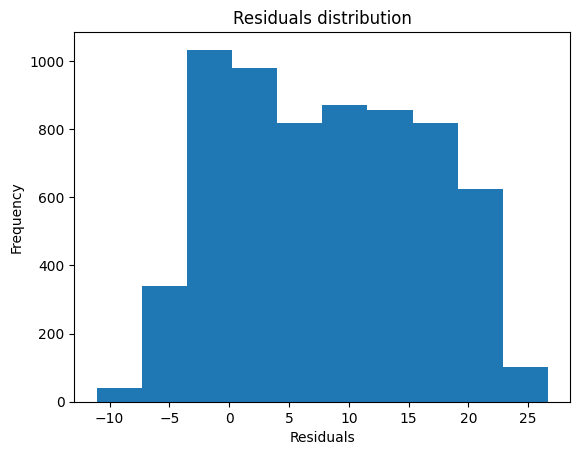

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


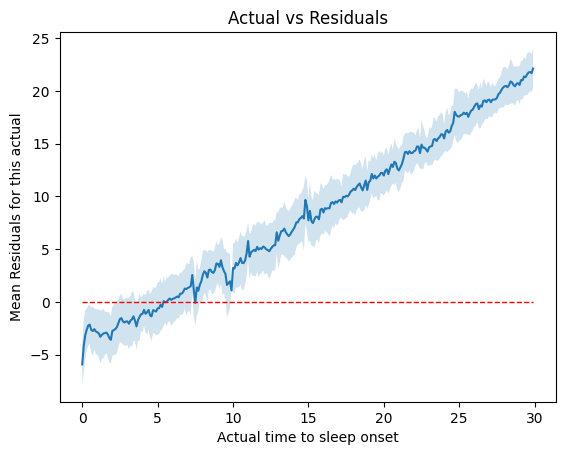

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_33541/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


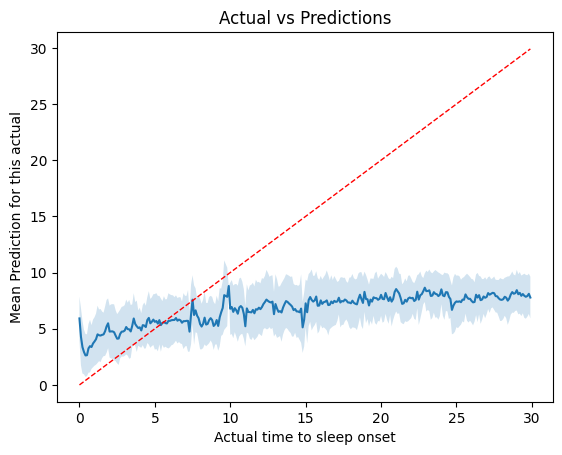

([51.876564025878906,
  39.31385040283203,
  81.40483093261719,
  44.540008544921875,
  26.768932342529297,
  56.57352066040039,
  57.387298583984375,
  37.82135009765625,
  25.185134887695312,
  21.219284057617188,
  63.18132400512695,
  25.325420379638672,
  36.906978607177734,
  76.59375762939453,
  28.994258880615234,
  114.02517700195312],
 [120.49458863586187,
  121.48610182962518,
  122.27312053922326,
  122.60876025037562,
  117.13373685485504,
  118.02935094513158,
  120.95703719381956,
  121.99652908044926,
  120.50794241609091,
  115.95087111249883,
  123.7642496992299,
  114.7085789819347,
  115.82457331837492,
  117.25949253173584,
  120.76948404232873,
  125.31613823422727],
 SleepOnsetESNRegressor(
   (fc): Linear(in_features=500, out_features=1, bias=True)
 ),
 [6.968827,
  7.1632423,
  5.793846,
  5.1556616,
  5.821213,
  5.8731956,
  6.1087637,
  5.818123,
  5.747055,
  5.258997,
  5.9610224,
  5.6450844,
  6.400134,
  6.8003006,
  6.4332047,
  7.3903737,
  7.1303473,

In [38]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, reservoir_size= 500,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=0.5, iftest=1, ifoutputpredictions=0, 
                                        if_stratified_sampling=1, ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss(), iftrainshuffle=True)